# Importing Necessary Libraries

These are some of the most important libraries which we need while making the project. 

In [5]:
import pandas as pd
import json
import numpy as np
from PIL import Image, ImageDraw
import os
import glob
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Here i am installing the labelme for labeling the images. which is then going to be used for the image masking

In [2]:
!pip install labelme

     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.4 MB 81.9 kB/s eta 0:00:17
     - -------------------------------------- 0.0/1.4 MB 81.9 kB/s eta 0:00:17
     - -------------------------------------- 0.0/1.4 MB 81.9 kB/s eta 0:00:17
     - -------------------------------------- 0.0/1.4 MB 81.9 kB/s eta 0:00:17
     - -------------------------------------- 0.0/1.4 MB 81.9 kB/s eta 0:00:17
     - ------------------------------

# Creating masks
Above, we have seen that we have installed the lableme which will convert our images to the JSON file which will further going to be converted to the mask which will be used during fitting the model.

In [2]:
json_dir = "random-image"
save_dir = "masks"
os.makedirs(save_dir, exist_ok=True)

#here we have gone through all the JSON files to convert it into masks
for json_file in glob.glob(os.path.join(json_dir, "*.json")):
    with open(json_file) as f:
        data = json.load(f)

    img_width = data['imageWidth']
    img_height = data['imageHeight']
    
    mask = Image.new("L", (img_width, img_height), 0)
    for shape in data['shapes']:
        polygon = [(int(x), int(y)) for x, y in shape['points']]  
        ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)  # Object = 1, background = 0

    mask_name = os.path.basename(json_file).replace(".json", "_mask.png")
    mask.save(os.path.join(save_dir, mask_name))

# Loading And Preprocessing

Now we are going to Load and preprocess the data we have collected according to out needs, Here we have saved the data of images in random-image and the masks in the masks_path. 

In the preprocessing part we are resizing the image in (128,128) form and normalizing it to make it under 0 to 1 for both images and the masks.

after doing these things we have putted that into the images array and other one for masks.

In [3]:
images_path = "random-image"
masks_path = "masks"

#Load and preprocess images and masks
images = []
masks = []

for img_name in os.listdir(images_path):
    img = Image.open(os.path.join(images_path, img_name))
    img = img.resize((128, 128))
    img = np.array(img) / 255.0
    images.append(img)

    mask_name = img_name.replace(".jpeg", "_mask.png")
    mask = Image.open(os.path.join(masks_path, mask_name))
    mask = mask.resize((64, 64))
    mask = np.array(mask) / 255.0 
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

# Creating model

Here we are going to create a model based on U-Net architecture at first we hae defined the model as improved_unet_model. This model is used for the segmentation things. here is the Encoder is for downsampling and decoder is for upsampling.

#### Encoder
after going inside we have taken a input size as (128,128,3) for the input layer. Here the 3 is for RGB color channels.
we have used Conv2D with 32 filters and relu as a activation function.
and MaxPooling2D layer will reduce the height and weight. 

#### Decoder
Now in this part we have used Conv2DTranspose layer with 32 layers to upsample our data and strides will help to double the height and width.

#### Final layer
after that we have concatenated the input and output layer with Conv2D layer with 1x1 kernel and sigmoid as activation function.

#### Compiling the model
For compiling the model we have used Adam optimizer at very low learning rate (0.00001) because our dataset is small which is why we need our model to learn slow. 

#### Data Augumentation

Now after all this we have added the data augumentation part because our dataset is of only 10 images which is not so big and will make underfitted. So we have used the data augumentataion.

In the augumentation we do some different things with the images data like rotation, image shift, zoom, flip and filling the missing pixel.

#### Training part
Now the next part is trainging the model.

#### Model Summary
It provides us summary about the layers, Including there output shapes and parameter count for each layer.

In [7]:
def improved_unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    #Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c2 = layers.MaxPooling2D((2, 2))(c2)
    #Decoder
    u1 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = models.Model(inputs, outputs)
    return model

model = improved_unet_model()
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

#Data Augumentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 2
epochs = 10
train_generator = datagen.flow(images, masks, batch_size=batch_size)
model.fit(train_generator, steps_per_epoch=len(images) // batch_size, epochs=epochs)


model.summary()

Epoch 1/10


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.0677 - loss: 0.7287
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0492 - loss: 0.7232

D:\anaconda\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0966 - loss: 0.7217
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1822 - loss: 0.7127
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4246 - loss: 0.7020
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3986 - loss: 0.7001
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │     18,464 │ max_pooling2d_5[… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     18,464 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64, 1) │         33 │ conv2d_10[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 169,061 (660.40 KB)

 Trainable params: 56,353 (220.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 112,708 (440.27 KB)

# Fitting the model

Here in this part we are going to fit out model on the data so we have used some important things for this like the images and masks.

we have taken 400 epochs because on taking low epochs our model doesn't learn properly. 
we took batch_size small because it will learn patterns slow and it is usefull because our model is small.
now on taking validation_split=0.1 means we are just leaving aroung 10% of the traning data out of epoch so that it will monitor the model's performance on new data.

In [33]:
model.fit(images, masks, epochs=400, batch_size=1, validation_split=0.1)

Epoch 1/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8134 - loss: 0.9922 - val_accuracy: 0.8313 - val_loss: 0.9923
Epoch 2/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7662 - loss: 0.9922 - val_accuracy: 0.8313 - val_loss: 0.9924
Epoch 3/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7810 - loss: 0.9923 - val_accuracy: 0.8313 - val_loss: 0.9924
Epoch 4/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7763 - loss: 0.9923 - val_accuracy: 0.8313 - val_loss: 0.9925
Epoch 5/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7911 - loss: 0.9922 - val_accuracy: 0.8313 - val_loss: 0.9926
Epoch 6/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7724 - loss: 0.9923 - val_accuracy: 0.8313 - val_loss: 0.9927
Epoch 7/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8059 - loss: 0.9923 - val_accuracy: 0.8313 - val_loss: 0.9926
Epoch 8/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7490 - loss: 0.9923 - val_accuracy: 0.8313 - val_loss:

# Fixing the Loss with dice loss

Dice loss we basically use for the binary segmentation part to maximize the overlap between predicted and actual segmentation.
it will handle the imbalanced classes effectively.

In [34]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth))

# Compile the model with dice loss
model.compile(optimizer=Adam(learning_rate=0.001), loss=dice_loss, metrics=['accuracy'])

# Testing the image

Here we are testing our model on the image. This predictes the predicted mask and then converts this mask into a binary format to clearly separate foreground and background areas and we have taken 0.35 as the threshold value to adjust the sensitivity.

In [35]:
test_image = images[6]
test_image = np.expand_dims(test_image, axis=0)

predicted_mask = model.predict(test_image)
predicted_mask = (predicted_mask > 0.35).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


In [36]:
predicted_mask

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]], dtype=uint8)

# Vizulising the Original image, Ground Truth, Predicted Mask

Now Coming to this part
here we have shown the 
1. Original image (the image we took for experimentation)
2. Ground Truth mask (This is the mask for that particular image which shows us that how mask is for that image.)
3. Predicted mask (This part shows us how our model has performed and shown that predicted mask for the image.)

After looking at the predicted mask we can say that our model is working really fine it gives us really good output. which we have seen during the epoch that our model gives 80% accuracy constantly.

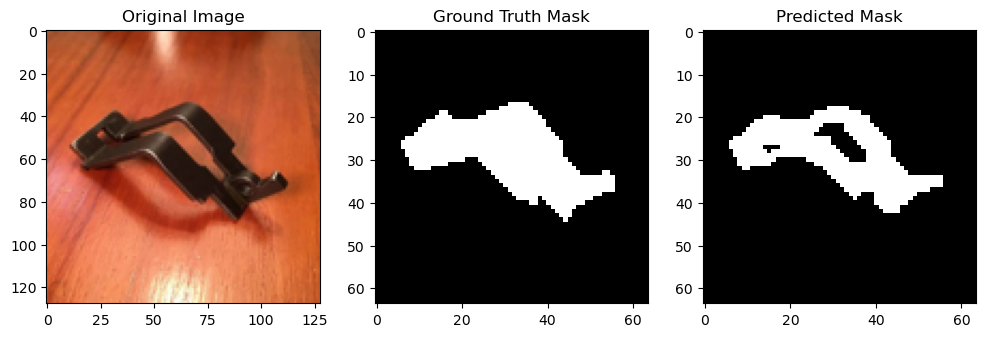

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

#original image
axs[0].imshow(images[6])
axs[0].set_title("Original Image")

#ground truth mask
axs[1].imshow(masks[6].squeeze(), cmap='gray')
axs[1].set_title("Ground Truth Mask")

#predicted mask
axs[2].imshow(predicted_mask.squeeze(), cmap='gray')
axs[2].set_title("Predicted Mask")

plt.show()

# Testing one new image

Here in this part we are trying to test our model on the new image. we really get a good result accroding to our model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
[[[[8.4925399e-27]
   [0.0000000e+00]
   [5.6162740e-25]
   ...
   [6.8843430e-28]
   [3.6932859e-34]
   [6.0931539e-14]]

  [[2.6531667e-37]
   [0.0000000e+00]
   [3.7402354e-38]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.1198767e-18]]

  [[2.1685295e-35]
   [0.0000000e+00]
   [1.2134022e-37]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.2750569e-18]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.9125040e-18]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.5348206e-37]]

  [[5.7385495e-32]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.2765589e-21]]]]


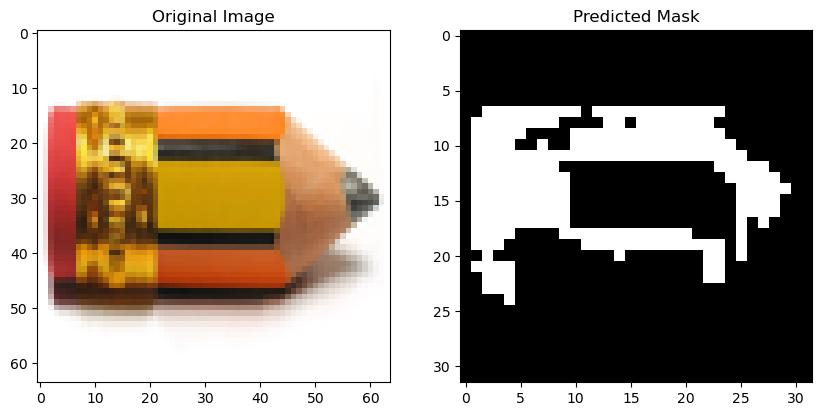

In [38]:
new_image_path = 'C:/Users/LENOVO/Desktop/Emborf-Project/test_image_file/test1.jpeg'
new_image = Image.open(new_image_path)
new_image = new_image.resize((64, 64))
new_image = np.array(new_image) / 255.0
new_image = np.expand_dims(new_image, axis=0)

predicted_mask = model.predict(new_image)

print(predicted_mask)

predicted_mask = (predicted_mask > 0.35).astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(np.squeeze(new_image))
ax1.set_title("Original Image")
ax2.imshow(np.squeeze(predicted_mask), cmap='gray')  #Squeeze to show mask
ax2.set_title("Predicted Mask")
plt.show()

# Summary

So, here form the starting the work goes like this
1. Collecting the images.
2. Creating the masks for the images.
3. Loading and preprocessing the image data according to our needs.
4. Creating the model.
5. Fitting the model.
6. Testing it on image
7. Vizualizing the original image, ground truth mask and the most important part predicted mask.
8. Testing our model on all new image.

# Thank-You